Per-second MEAN:  corr = 0.533586,  MSE = 0.000033,  MAE = 0.003540
Per-second SUM :  corr = 0.530386,  MSE = 0.000261,  MAE = 0.008748


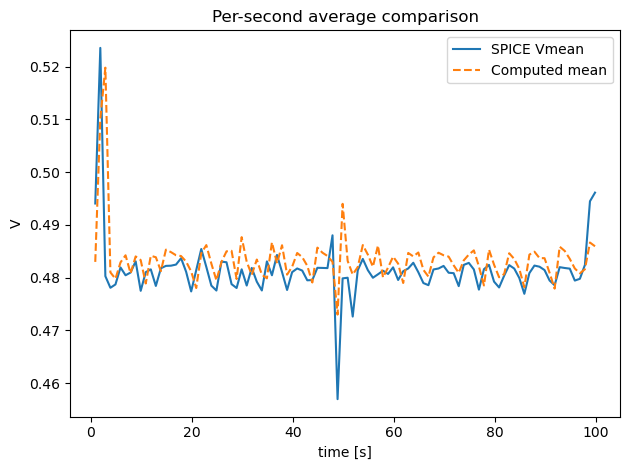

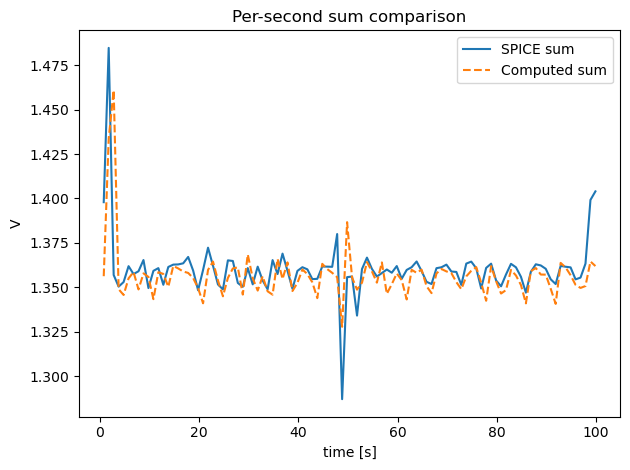

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# ---------- 1. Load data ----------
# CSV = "mean_sum_validation_rchalfhalf.csv"
# CSV = "mean_sum_validation_c10p.csv"
CSV = "mean_sum_validation_c25.csv"
df = pd.read_csv(CSV)

# Convenience handles (adapt if your header changes)
t_col  = "/Vmean (flg_global_she=-1) X"
vin_col   = "/Vin (flg_global_she=-1) Y"
vmean_col = "/Vmean (flg_global_she=-1) Y"
vsum_col  = "/Vsum (flg_global_she=-1) Y"

inputshift = 1
vref = 1.5
N = 3

time        = df[t_col].to_numpy()
vin         = df[vin_col].to_numpy() - inputshift
vmean_spice = df[vmean_col].to_numpy() - inputshift
vsum_spice  = df[vsum_col].to_numpy()

vsum_spice = vsum_spice + (N - 1) * vref - N * inputshift  # -N because the 1 V shift is scaled

# ---------- 2. Pick one SPICE sample every full second (0.85 s + k) ----------
sample_times = np.arange(0.85, time.max(), 1.0)
idx_sample   = np.searchsorted(time, sample_times)
idx_sample   = np.clip(idx_sample, 0, len(time) - 1)

vmean_sp_sampled = vmean_spice[idx_sample]
vsum_sp_sampled  = vsum_spice[idx_sample]

# ---------- 3. Compute 1-second statistics from raw Vin ----------
window_starts = np.floor(sample_times).astype(int)
calc_mean, calc_sum = [], []

for ws in window_starts:
    mask = (time >= ws) & (time < ws + 1)
    segment = vin[mask]
    if segment.size == 0:
        calc_mean.append(np.nan)
        calc_sum.append(np.nan)
        continue

    calc_mean.append(segment.mean())           # whole-second mean

    # sum of exactly 32 samples
    if segment.size >= 32:
        idx = np.linspace(0, segment.size - 1, 32, dtype=int)
        calc_sum.append(segment[idx].sum())
    else:
        calc_sum.append(segment.sum())

calc_mean = np.asarray(calc_mean)
calc_sum  = np.asarray(calc_sum)

# ---------- 4. Metrics ----------
def mse(a, b): return np.mean((a - b) ** 2)
def mae(a, b): return np.mean(np.abs(a - b))     

calc_sum = calc_sum / 11 - 0.05
corr_mean = pearsonr(calc_mean, vmean_sp_sampled)[0]
corr_sum  = pearsonr(calc_sum , vsum_sp_sampled )[0]

mse_mean = mse(calc_mean, vmean_sp_sampled)
mse_sum  = mse(calc_sum , vsum_sp_sampled)
mae_mean = mae(calc_mean, vmean_sp_sampled)       
mae_sum  = mae(calc_sum , vsum_sp_sampled)        

print(f"Per-second MEAN:  corr = {corr_mean:8.6f},  MSE = {mse_mean:8.6f},  MAE = {mae_mean:8.6f}")
print(f"Per-second SUM :  corr = {corr_sum :8.6f},  MSE = {mse_sum :8.6f},  MAE = {mae_sum :8.6f}")

# ---------- 5. Quick visual sanity check (optional) ----------
plt.figure()
plt.plot(sample_times, vmean_sp_sampled, label="SPICE Vmean")
plt.plot(sample_times, calc_mean, "--", label="Computed mean")
plt.xlabel("time [s]"); plt.ylabel("V")
plt.title("Per-second average comparison")
plt.legend(); plt.tight_layout()
plt.show()

plt.figure()
plt.plot(sample_times, vsum_sp_sampled, label="SPICE sum")
plt.plot(sample_times, calc_sum, "--", label="Computed sum")
plt.xlabel("time [s]"); plt.ylabel("V")
plt.title("Per-second sum comparison")
plt.legend(); plt.tight_layout()
plt.show()
